In [81]:
from sqlalchemy import create_engine
import pandas as pd 
import numpy as np 

engine = create_engine('mysql+pymysql://root:Skdmlekdrh0707/@127.0.0.1:3306/stock_db')

ticker_list = pd.read_sql("""select * FROM kor_ticker where 기준일 = (select max(기준일) from kor_ticker) and 종목구분 = '보통주'; """ , con=engine)

value_list = pd.read_sql("""
select * FROM kor_value 
where 기준일 = (select max(기준일) from kor_value)""" , con=engine)

engine.dispose()

# 가치주 효과를 확인했으니 , 가치주 포트폴리오를 구성해보자

In [82]:
value_list

,종목코드,기준일,지표,값
0,000020,2024-06-12,DY,0.0221
1,000020,2024-06-12,PBR,0.5658
2,000020,2024-06-12,PCR,7.4545
3,000020,2024-06-12,PER,12.4242
4,000020,2024-06-12,PSR,0.5974
...,...,...,...,...
10808,472850,2024-06-12,PSR,NaN
10809,475150,2024-06-12,PBR,NaN
10810,475150,2024-06-12,PCR,NaN
10811,475150,2024-06-12,PER,NaN


In [83]:
value_list.loc[value_list['값'] <= 0 , '값'] = np.nan
value_pivot = value_list.pivot(index = '종목코드', columns = '지표', values = '값')
data_bind = ticker_list[['종목코드', '종목명']].merge(value_pivot , how = 'left' , on = '종목코드')

data_bind.head()

#여기서 DY는 dividen yield 로 주당 연간 배당금/ 주가 *100 이다. (이게 높으면 회사가 안정적일 수 있다)

,종목코드,종목명,DY,PBR,PCR,PER,PSR
0,000020,동화약품,0.0221,0.5658,7.4545,12.4242,0.5974
1,000040,KR모터스,NaN,1.8907,NaN,NaN,0.5162
2,000050,경방,0.0157,0.2957,3.5129,NaN,0.5464
3,000070,삼양홀딩스,0.0497,0.2199,2.2183,2.4997,0.1834
4,000080,하이트진로,0.0458,1.3128,26.0335,36.6567,0.5734


In [84]:
value_rank = data_bind[['PER', 'PBR']].rank(axis=0)

In [85]:
value_rank = data_bind[['PER', 'PBR']].rank(axis=0) #각 열별로 랭크가 값으로 들어감 
value_sum = value_rank.sum(axis= 1 , skipna = False).rank() #두 열의 랭킹을 합해서 다시 랭킹값을 구함 
data_bind.loc[value_sum <= 20 , ['종목코드', '종목명', 'PER', 'PBR']]
#보면 홀딩스(지주회사) 가 많이 있는데 이는 지주회사(토스코어) 로써 비핵심자산 (부동산, 계열사 주식) 등을 가지고 있음. 수익을 직접적으로 창출하거나 현금흐름이 유동적이지는 않은 경우가 많아 , per , pbr 이 낮게 평가된다. 
# 그리고 이런 자산 구조때문에 분석가나 외부 투자자들이 평가하기 다소 어려워서 per , pbr 를 낮게 보는 것도 있음 

,종목코드,종목명,PER,PBR
18,000370,한화손해보험,2.3597,0.1658
27,000540,흥국화재,0.9490,0.1899
57,001230,동국홀딩스,0.7688,0.1891
65,001390,KG케미칼,1.1262,0.0980
153,003300,한일홀딩스,1.9692,0.1892
247,005720,넥센,1.6590,0.1149
262,005990,매일홀딩스,1.2581,0.1569
289,006840,AK홀딩스,1.8755,0.1478
315,007700,F&F홀딩스,1.6355,0.1941
320,007860,서연,1.0297,0.1807


In [100]:
data_bind.head()
filtered_data = data_bind.copy()
# filtered_data = data_bind[~data_bind['종목명'].str.contains('홀딩스')]
# filtered_data.head()

In [101]:
import matplotlib.pyplot as plt 
import seaborn as sns 

value_list_copy = filtered_data.copy()

value_list_copy['DY'] = 1 / value_list_copy['DY'] #다른 팩터의 경우, 낮을수록 가치주. 배당금은 높을 수록 가치주이므로 순서를 똑같게 한다. 
value_list_copy = value_list_copy[['PER' , 'PBR', 'PCR', 'PSR', 'DY']]
value_rank_all = value_list_copy.rank(axis=0)
mask = np.triu(value_rank_all.corr()) #행렬로 바꿔줌 , upper triangulr matrix 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


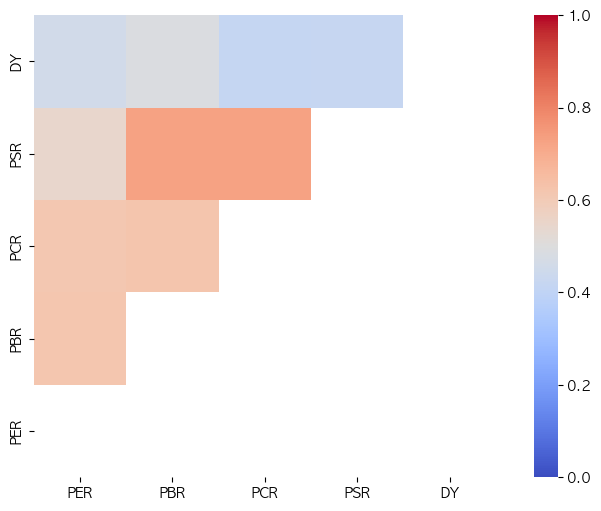

[[1.         0.62066685 0.61671432 0.54519053 0.45584323]
 [0.         1.         0.62202626 0.73003269 0.49118774]
 [0.         0.         1.         0.72974124 0.41615332]
 [0.         0.         0.         1.         0.42011828]
 [0.         0.         0.         0.         1.        ]]


In [102]:
fig, ax = plt.subplots(figsize= (10,6))
sns.heatmap(value_rank_all.corr() , 
            annot=True,
            fmt=".2f",  # 소수점 둘째 자리까지 표시
            mask=mask,
            annot_kws={"size": 16},
            vmin=0,
            vmax=1,  # 상관계수 범위를 0에서 1로 설정
            center=0.5,
            cmap='coolwarm',
            square=True
)
ax.invert_yaxis()
plt.show()
print(mask)

#상관관계 값이 높은 것도 있지미나 , 연견 배당금과는 관련이 크게 없음

In [103]:
value_sum_all = value_rank_all.sum(axis = 1, skipna=False).rank()
filtered_data.loc[value_sum_all <= 20] 

,종목코드,종목명,DY,PBR,PCR,PER,PSR
3,000070,삼양홀딩스,0.0497,0.2199,2.2183,2.4997,0.1834
17,000320,노루홀딩스,0.0402,0.2403,1.6255,2.6819,0.1355
57,001230,동국홀딩스,0.0723,0.1891,0.7279,0.7688,0.1458
65,001390,KG케미칼,0.0233,0.0980,1.1009,1.1262,0.0400
153,003300,한일홀딩스,0.0601,0.1892,1.3486,1.9692,0.1775
206,004690,삼천리,0.0328,0.2200,2.3409,2.6712,0.0702
247,005720,넥센,0.0261,0.1149,0.6667,1.6590,0.0833
262,005990,매일홀딩스,0.0241,0.1569,0.6422,1.2581,0.0530
372,009970,영원무역홀딩스,0.0488,0.2457,1.3034,1.6842,0.2617
492,016450,한세예스24홀딩스,0.0529,0.2117,0.8792,1.8002,0.0687
